## Imports and Helper Functions

In [33]:
from comet_ml import Experiment
import torch
import os
import random
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl
from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

from pytorch_lightning.loggers import CometLogger

root = os.environ['SLURM_TMPDIR']

In [34]:
len(glob(root+'/gt_full2/train/images/*.jpg')), len(glob(root+'/gt_full2/test/images/*.jpg')), len(glob(root+'/gt_full2/val/images/*.jpg'))

(1076797, 143796, 51592)

In [35]:
import colorsys
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

def plot_pts(fname, gt, preds, pts, c, title):
    cols = np.zeros((len(gt),3))
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.grid(color='gray', linestyle='dashed')
    plt.scatter(0, 0, marker='*', s=200)
    plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
    plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
    plt.xlabel('distance from the camera at origin in x direction (cm)')
    plt.ylabel('distance from the camera at origin in y direction (cm)')
    plt.axis('equal')

## Load model and weights

In [36]:
f = root+'/gt_full2/test/images/'
weight_file = './checkpoint.ckpt'

print(weight_file)
print('Number of test files: ', len(glob(f+"*.jpg")))

./checkpoint.ckpt
Number of test files:  143796


In [37]:
model = gazetrack_model()
w = torch.load(weight_file)['state_dict']
model.load_state_dict(w)
model.cuda()
model.eval()

preds, gt, ors = [], [], []
ctr = 1
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=10, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target, ori = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda(), j[-1]
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  
    ors.extend(ori)
    
    gt.extend(target.detach().cpu().numpy())
    
preds = np.array(preds)
gt = np.array(gt)
ors = np.array(ors)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

  0%|          | 0/281 [00:00<?, ?it/s]

Num files for test = 143796


100%|██████████| 281/281 [00:56<00:00,  4.93it/s]


Mean Euclidean Distance:  2.0095606


In [38]:
print("Portrait orientation: ", np.mean(dist[np.where(ors==2)]))
print("Landscape, with home button on the right: ", np.mean(dist[np.where(ors==1)]))
print("Landscape, with home button on the left: ", np.mean(dist[np.where(ors==0)]))

Portrait orientation:  2.0337548
Landscape, with home button on the right:  2.0637705
Landscape, with home button on the left:  1.9330263


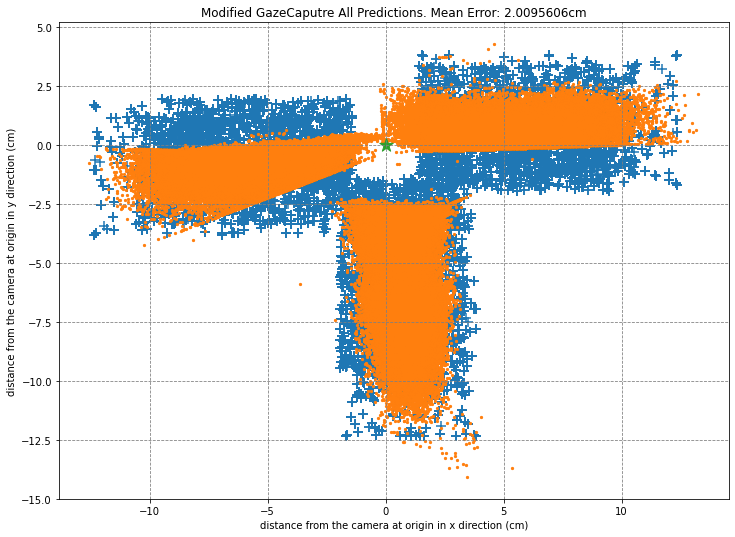

In [39]:
import colorsys
import random

def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

c = get_colors(30)
random.shuffle(c)
def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))
    
plt.figure(figsize=(12,12))
plt.title('Modified GazeCaputre All Predictions. Mean Error: '+str(dist.mean())+"cm")
plt.grid(color='gray', linestyle='dashed')

plt.scatter(gt[:,0], gt[:,1],  marker='+', s=100)
plt.scatter(preds[:,0], preds[:,1], s=5)
plt.scatter(0, 0, marker='*', s=200)



plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.savefig('GTFull')

## Test Participant Wise

In [40]:
all_files = glob(f+"/*.jpg")
all_files = [i[:-10] for i in all_files]
files = np.unique(all_files)
print('Found ', len(all_files), ' images from ', len(files), ' subjects.')

fnames = []
nums = []
for i in tqdm(files):
    fnames.append(i)
    nums.append(len(glob(i+"*.jpg")))
fnames = np.array(fnames)
nums = np.array(nums)
ids = np.argsort(nums)
ids = ids[::-1]
fnames_sorted = fnames[ids]
nums_sorted = nums[ids]
files = fnames_sorted.copy()
nums_sorted[0], nums_sorted[-1], sum(nums_sorted)

  1%|          | 1/121 [00:00<00:17,  6.70it/s]

Found  143796  images from  121  subjects.


100%|██████████| 121/121 [00:17<00:00,  6.76it/s]


(2450, 79, 143796)

In [41]:
total_test = {}

for idx in tqdm(range(len(files))):    
    preds, gt = [], []
    ctr = 1
    f = files[idx]
    test_dataset = gazetrack_dataset(f, phase='test')
    test_dataloader = DataLoader(test_dataset, batch_size=100, num_workers=10, pin_memory=False, shuffle=False,)

    for j in test_dataloader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.detach().cpu().numpy()
        preds.extend(pred)  

        gt.extend(target.detach().cpu().numpy())

    preds = np.array(preds)
    pts = np.unique(gt, axis=0)

    gt = np.array(gt)
    dist = euc(preds, gt)
    total_test[f] = [dist, gt, preds, pts]

  0%|          | 0/121 [00:00<?, ?it/s]

Num files for test = 2450


  1%|          | 1/121 [00:02<04:51,  2.43s/it]

Num files for test = 2418


  2%|▏         | 2/121 [00:04<04:54,  2.48s/it]

Num files for test = 2296


  2%|▏         | 3/121 [00:07<04:41,  2.39s/it]

Num files for test = 2281


  3%|▎         | 4/121 [00:09<04:37,  2.37s/it]

Num files for test = 2238


  4%|▍         | 5/121 [00:11<04:33,  2.35s/it]

Num files for test = 2202


  5%|▍         | 6/121 [00:14<04:28,  2.34s/it]

Num files for test = 2127


  6%|▌         | 7/121 [00:16<04:25,  2.33s/it]

Num files for test = 2101


  7%|▋         | 8/121 [00:18<04:19,  2.30s/it]

Num files for test = 2063


  7%|▋         | 9/121 [00:20<04:14,  2.27s/it]

Num files for test = 2063


  8%|▊         | 10/121 [00:23<04:12,  2.27s/it]

Num files for test = 2053


  9%|▉         | 11/121 [00:25<04:08,  2.26s/it]

Num files for test = 2053


 10%|▉         | 12/121 [00:27<04:09,  2.29s/it]

Num files for test = 2050


 11%|█         | 13/121 [00:29<04:03,  2.26s/it]

Num files for test = 2032


 12%|█▏        | 14/121 [00:32<03:58,  2.23s/it]

Num files for test = 2012


 12%|█▏        | 15/121 [00:34<03:52,  2.20s/it]

Num files for test = 1997


 13%|█▎        | 16/121 [00:36<03:46,  2.16s/it]

Num files for test = 1939


 14%|█▍        | 17/121 [00:38<03:42,  2.14s/it]

Num files for test = 1927


 15%|█▍        | 18/121 [00:40<03:39,  2.13s/it]

Num files for test = 1922


 16%|█▌        | 19/121 [00:42<03:35,  2.11s/it]

Num files for test = 1920


 17%|█▋        | 20/121 [00:44<03:33,  2.11s/it]

Num files for test = 1825


 17%|█▋        | 21/121 [00:46<03:28,  2.09s/it]

Num files for test = 1788


 18%|█▊        | 22/121 [00:48<03:24,  2.06s/it]

Num files for test = 1774


 19%|█▉        | 23/121 [00:50<03:18,  2.03s/it]

Num files for test = 1771


 20%|█▉        | 24/121 [00:52<03:16,  2.02s/it]

Num files for test = 1748


 21%|██        | 25/121 [00:54<03:14,  2.02s/it]

Num files for test = 1733


 21%|██▏       | 26/121 [00:56<03:08,  1.99s/it]

Num files for test = 1721


 22%|██▏       | 27/121 [00:58<03:07,  2.00s/it]

Num files for test = 1716


 23%|██▎       | 28/121 [01:00<03:08,  2.02s/it]

Num files for test = 1666


 24%|██▍       | 29/121 [01:02<03:04,  2.01s/it]

Num files for test = 1658


 25%|██▍       | 30/121 [01:04<03:03,  2.02s/it]

Num files for test = 1640


 26%|██▌       | 31/121 [01:06<02:56,  1.96s/it]

Num files for test = 1629


 26%|██▋       | 32/121 [01:08<02:55,  1.97s/it]

Num files for test = 1618


 27%|██▋       | 33/121 [01:10<02:51,  1.94s/it]

Num files for test = 1557


 28%|██▊       | 34/121 [01:12<02:47,  1.93s/it]

Num files for test = 1540


 29%|██▉       | 35/121 [01:14<02:49,  1.97s/it]

Num files for test = 1514


 30%|██▉       | 36/121 [01:16<02:45,  1.95s/it]

Num files for test = 1511


 31%|███       | 37/121 [01:18<02:41,  1.93s/it]

Num files for test = 1505


 31%|███▏      | 38/121 [01:20<02:38,  1.91s/it]

Num files for test = 1505


 32%|███▏      | 39/121 [01:21<02:35,  1.90s/it]

Num files for test = 1496


 33%|███▎      | 40/121 [01:23<02:31,  1.87s/it]

Num files for test = 1483


 34%|███▍      | 41/121 [01:25<02:30,  1.88s/it]

Num files for test = 1481


 35%|███▍      | 42/121 [01:27<02:32,  1.92s/it]

Num files for test = 1471


 36%|███▌      | 43/121 [01:29<02:28,  1.90s/it]

Num files for test = 1468


 36%|███▋      | 44/121 [01:31<02:24,  1.88s/it]

Num files for test = 1460


 37%|███▋      | 45/121 [01:33<02:23,  1.89s/it]

Num files for test = 1458


 38%|███▊      | 46/121 [01:35<02:19,  1.86s/it]

Num files for test = 1453


 39%|███▉      | 47/121 [01:36<02:17,  1.86s/it]

Num files for test = 1424


 40%|███▉      | 48/121 [01:38<02:16,  1.86s/it]

Num files for test = 1419


 40%|████      | 49/121 [01:40<02:13,  1.85s/it]

Num files for test = 1372


 41%|████▏     | 50/121 [01:42<02:09,  1.83s/it]

Num files for test = 1371


 42%|████▏     | 51/121 [01:44<02:08,  1.83s/it]

Num files for test = 1364


 43%|████▎     | 52/121 [01:46<02:06,  1.83s/it]

Num files for test = 1343


 44%|████▍     | 53/121 [01:47<02:03,  1.82s/it]

Num files for test = 1288


 45%|████▍     | 54/121 [01:49<02:01,  1.81s/it]

Num files for test = 1279


 45%|████▌     | 55/121 [01:51<02:00,  1.82s/it]

Num files for test = 1248


 46%|████▋     | 56/121 [01:53<01:54,  1.77s/it]

Num files for test = 1240


 47%|████▋     | 57/121 [01:55<01:55,  1.81s/it]

Num files for test = 1209


 48%|████▊     | 58/121 [01:56<01:53,  1.81s/it]

Num files for test = 1200


 49%|████▉     | 59/121 [01:58<01:53,  1.83s/it]

Num files for test = 1196


 50%|████▉     | 60/121 [02:00<01:48,  1.78s/it]

Num files for test = 1182


 50%|█████     | 61/121 [02:02<01:46,  1.77s/it]

Num files for test = 1147


 51%|█████     | 62/121 [02:03<01:45,  1.78s/it]

Num files for test = 1144


 52%|█████▏    | 63/121 [02:05<01:44,  1.80s/it]

Num files for test = 1125


 53%|█████▎    | 64/121 [02:07<01:42,  1.80s/it]

Num files for test = 1117


 54%|█████▎    | 65/121 [02:09<01:39,  1.78s/it]

Num files for test = 1103


 55%|█████▍    | 66/121 [02:11<01:38,  1.78s/it]

Num files for test = 1092


 55%|█████▌    | 67/121 [02:12<01:36,  1.78s/it]

Num files for test = 1076


 56%|█████▌    | 68/121 [02:14<01:34,  1.78s/it]

Num files for test = 1063


 57%|█████▋    | 69/121 [02:16<01:33,  1.79s/it]

Num files for test = 1020


 58%|█████▊    | 70/121 [02:18<01:30,  1.77s/it]

Num files for test = 1000


 59%|█████▊    | 71/121 [02:19<01:27,  1.74s/it]

Num files for test = 988


 60%|█████▉    | 72/121 [02:21<01:23,  1.71s/it]

Num files for test = 975


 60%|██████    | 73/121 [02:23<01:21,  1.71s/it]

Num files for test = 973


 61%|██████    | 74/121 [02:24<01:20,  1.70s/it]

Num files for test = 965


 62%|██████▏   | 75/121 [02:26<01:18,  1.71s/it]

Num files for test = 962


 63%|██████▎   | 76/121 [02:28<01:17,  1.73s/it]

Num files for test = 952


 64%|██████▎   | 77/121 [02:30<01:16,  1.73s/it]

Num files for test = 905


 64%|██████▍   | 78/121 [02:31<01:13,  1.70s/it]

Num files for test = 875


 65%|██████▌   | 79/121 [02:33<01:10,  1.68s/it]

Num files for test = 874


 66%|██████▌   | 80/121 [02:35<01:08,  1.66s/it]

Num files for test = 842


 67%|██████▋   | 81/121 [02:36<01:07,  1.69s/it]

Num files for test = 833


 68%|██████▊   | 82/121 [02:38<01:05,  1.68s/it]

Num files for test = 802


 69%|██████▊   | 83/121 [02:40<01:04,  1.69s/it]

Num files for test = 790


 69%|██████▉   | 84/121 [02:41<01:02,  1.68s/it]

Num files for test = 779


 70%|███████   | 85/121 [02:43<01:00,  1.69s/it]

Num files for test = 771


 71%|███████   | 86/121 [02:45<00:57,  1.66s/it]

Num files for test = 740


 72%|███████▏  | 87/121 [02:46<00:55,  1.64s/it]

Num files for test = 734


 73%|███████▎  | 88/121 [02:48<00:54,  1.65s/it]

Num files for test = 732


 74%|███████▎  | 89/121 [02:50<00:52,  1.64s/it]

Num files for test = 710


 74%|███████▍  | 90/121 [02:51<00:50,  1.63s/it]

Num files for test = 706


 75%|███████▌  | 91/121 [02:53<00:48,  1.62s/it]

Num files for test = 697


 76%|███████▌  | 92/121 [02:54<00:46,  1.62s/it]

Num files for test = 693


 77%|███████▋  | 93/121 [02:56<00:45,  1.62s/it]

Num files for test = 689


 78%|███████▊  | 94/121 [02:58<00:43,  1.61s/it]

Num files for test = 677


 79%|███████▊  | 95/121 [02:59<00:42,  1.63s/it]

Num files for test = 657


 79%|███████▉  | 96/121 [03:01<00:40,  1.63s/it]

Num files for test = 637


 80%|████████  | 97/121 [03:02<00:37,  1.57s/it]

Num files for test = 618


 81%|████████  | 98/121 [03:04<00:36,  1.59s/it]

Num files for test = 608


 82%|████████▏ | 99/121 [03:06<00:35,  1.60s/it]

Num files for test = 539


 83%|████████▎ | 100/121 [03:07<00:32,  1.57s/it]

Num files for test = 513


 83%|████████▎ | 101/121 [03:09<00:31,  1.55s/it]

Num files for test = 508


 84%|████████▍ | 102/121 [03:10<00:29,  1.58s/it]

Num files for test = 502


 85%|████████▌ | 103/121 [03:12<00:28,  1.56s/it]

Num files for test = 428


 86%|████████▌ | 104/121 [03:13<00:25,  1.52s/it]

Num files for test = 425


 87%|████████▋ | 105/121 [03:15<00:24,  1.52s/it]

Num files for test = 423


 88%|████████▊ | 106/121 [03:16<00:22,  1.53s/it]

Num files for test = 413


 88%|████████▊ | 107/121 [03:18<00:21,  1.50s/it]

Num files for test = 383


 89%|████████▉ | 108/121 [03:19<00:19,  1.51s/it]

Num files for test = 382


 90%|█████████ | 109/121 [03:21<00:17,  1.50s/it]

Num files for test = 340


 91%|█████████ | 110/121 [03:22<00:16,  1.48s/it]

Num files for test = 310


 92%|█████████▏| 111/121 [03:24<00:14,  1.50s/it]

Num files for test = 300


 93%|█████████▎| 112/121 [03:25<00:13,  1.47s/it]

Num files for test = 260


 93%|█████████▎| 113/121 [03:27<00:11,  1.48s/it]

Num files for test = 246


 94%|█████████▍| 114/121 [03:28<00:10,  1.47s/it]

Num files for test = 243


 95%|█████████▌| 115/121 [03:29<00:08,  1.47s/it]

Num files for test = 231


 96%|█████████▌| 116/121 [03:31<00:07,  1.48s/it]

Num files for test = 222


 97%|█████████▋| 117/121 [03:33<00:06,  1.50s/it]

Num files for test = 198


 98%|█████████▊| 118/121 [03:34<00:04,  1.49s/it]

Num files for test = 163


 98%|█████████▊| 119/121 [03:35<00:02,  1.47s/it]

Num files for test = 149


 99%|█████████▉| 120/121 [03:37<00:01,  1.45s/it]

Num files for test = 79


100%|██████████| 121/121 [03:38<00:00,  1.81s/it]


Text(0, 0.5, 'Mean Euclidean Distance')

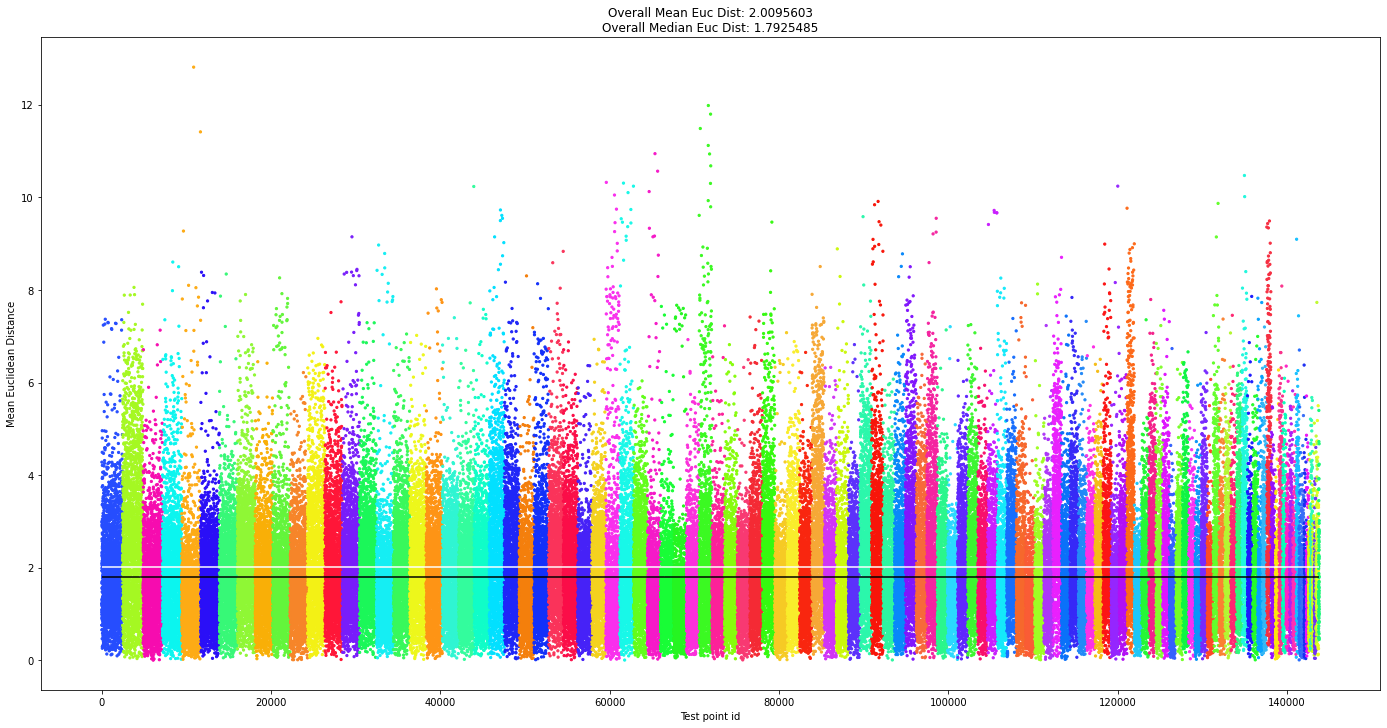

In [45]:
mean_errs = []
cols = []
c = get_colors(len(total_test))
random.shuffle(c)
for idx, i in enumerate(total_test):
    mean_errs.extend(total_test[i][0])
    cols.extend([c[idx] for j in range(len(total_test[i][0]))])
    
plt.figure(figsize=(24, 12))
plt.title("Overall Mean Euc Dist: "+str(np.mean(mean_errs)) + "\nOverall Median Euc Dist: "+str(np.median(mean_errs)))
plt.scatter([i for i in range(len(mean_errs))], mean_errs,c=cols, s=5)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='white')
plt.hlines(y=np.median(mean_errs), xmin=0, xmax=len(mean_errs), color='black')
plt.xlabel('Test point id')
plt.ylabel('Mean Euclidean Distance')


## Random Test

device:  iPhone 5S
id:  2
Num files:  2296
Sample:


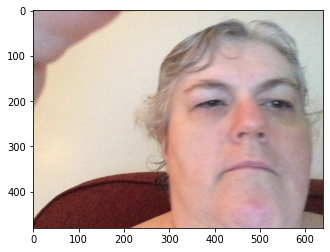

In [49]:
idx = 2
meta = json.load(open(glob(files[idx].replace('images', 'meta')+"*.json")[0]))
print("device: ", meta['device'])
print("id: ", idx)
print("Num files: ", len(glob(files[idx]+"*.jpg")))
print("Sample:")
plt.imshow(plt.imread(glob(files[idx]+"*.jpg")[0]))

Num files for test = 2296
Mean Euclidean Distance:  1.7511724


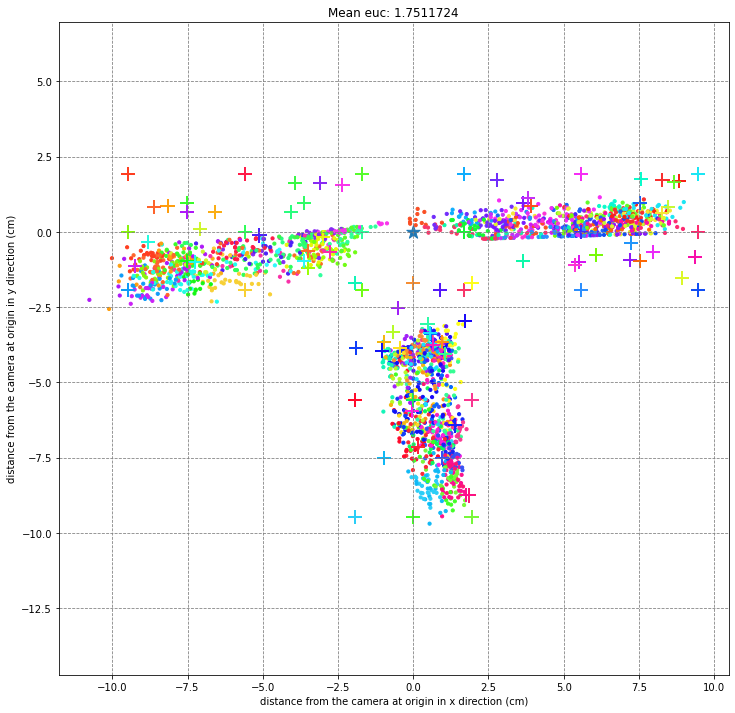

In [50]:
preds, gt = [], []
ctr = 1
f = files[idx]
fs = glob(f+"*.jpg")
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

preds, gt = [], []
for j in test_dataloader:
    leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  

    gt.extend(target.detach().cpu().numpy())

preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())
plot_pts(f, gt, preds, pts, c, "Mean euc: "+str(dist.mean()))